# MetOcean Solutions Observation API connector

Author: Sebastien Delaux

This notebook describes how to get observation data from one of MetOcean Solutions' observation API.

The data that can be accessed though the API come from different sources such as MetService's automatic weather station network, a number of wave buoys and tidal gages owned by various organisations. Different instances of the API are used for different sources. This connector should work for all of them.

The API provides the data as sets of records that belong to a station.
Each station is identified by a unique id string. Each station has its own metadata describing location, instrument, ownership, status, license and level of permission. If the station is not open then anyone interested to use the data needs to get in contact with MetOcean to negotiate access to the data. Any access to data non data will be done using the same connector but authentication will need to be set when initialising the connector.

For now the connector allows to retrieve data in the shape of xarray datasets.

A complete documentation of the API can be found here: https://observations-open.metoceanapi.com/api/swagger/


## Installation of required libraries

Install and import xarray and matplotlib in the current Jupyter kernel.
Xarray is a great library to work with data stored using NetCDF format. MetOcean's Observation API can provide data under the form of netCDF-like JSON and hence xarray is a great option to work with that data.
Matplotlib will used to plot the data.

In [1]:
import sys
!{sys.executable} -m pip install xarray matplotlib
import xarray

  Using cached https://files.pythonhosted.org/packages/ee/11/fb2a8a6015e3de4ff19a4870bb0d11f48ebdd997062557d24cd076b3088f/xarray-0.15.1-py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/93/4b/52da6b1523d5139d04e02d9e26ceda6146b48f2a4e5d2abfdf1c7bac8c40/matplotlib-3.2.1-cp36-cp36m-manylinux1_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/07/08/a549ba8b061005bb629b76adc000f3caaaf881028b963c2e18f811c6edc1/numpy-1.18.2-cp36-cp36m-manylinux1_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/a0/df/635cdb901ee4a8a42ec68e480c49f85f4c59e8816effbf57d9e6ee8b3588/setuptools-46.1.3-py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/bb/71/8f53bdbcbc67c912b888b40def255767e475402e9df64050019149b1a943/pandas-1.0.3-cp36-cp36m-manylinux1_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/d4/70/d60450c3dd48ef87586924207ae8907090de0b306af2bce5d134d78615cb/python_dateutil-2.8.1-py2.py3-none-any.whl
  Using cached ht

Install and import cf-json extension to xarray which will be used to turn netCDF-like json as returned by the API into an xarray Dataset

In [2]:
!{sys.executable} -m pip install git+ssh://git@github.com/metocean/cf-json@v0.3.3
from cfjson.xrdataset import CFJSONinterface

  Cloning ssh://git@github.com/metocean/cf-json (to v0.3.3) to /tmp/pip-l_u_emhl-build
  Running setup.py install for cfjson ... done


Import request library to query the API and path module of os package to help building url

In [3]:
import requests
from os import path

## Definition of connector

Declare a new exception class that can be used to identify any exception raised by the connector

In [4]:
class MetOceanObsAPIException(Exception):
    def __init__(self, message, obj=None, obj_name=None, status=400):
        self.message = message
        self.obj = obj
        self.obj_name = obj_name
        self.status = status
        super(ThreddsServerConnector, self).__init__(message)

Definition of connector

In [5]:
class MetOceanObsAPIConnector(object):
    """
    A class used to connect one of MetOcean Solution's instances
    of their observation API.
    
    Attributes
    ----------
    root_url : str
        The root url of the service
        
    Methods
    -------
    get_station_metadata(station_id)
        return the metadata associated with a given observation station
    get_data()
        return observation data retrieved from the API in the form of a xarray dataset object
    """
    
    def __init__(self,
                 root_url="https://observations-open.metoceanapi.com",
                 username=None, password=None, api_key=None):
        """
        Initialise the connector
        
        Parameters
        ----------
        root_url : str
            The url of the observation API to connect to. (default is https://observations-open.metoceanapi.com)
        username : str
            The username to use to connect the API
        password : str
            The password to use to connect the API
        api_key : str
            The api_key to use to connect the API
                
        Raises
        ------
        NotImplementedError
            If any of the authentication parameters is set.
        """
    
        self.root_url = path.join(root_url, 'api/stations')
        
        if username or password or api_key:
            raise NotImplementedError("Secure authentication is yet to be implemented for the connector")
    
        
    def get_station_metadata(self, station_id):
        """
        Get the metadata associated with a given observation station
        
        Parameters
        ----------
        station_id : str
            The id of the station to return the metadata for.
            
        Raises
        ------
        MetOceanObsAPIException
            If query did not return with 200 status code
            
        Returns
        -------
        dict
            A dictionary containing the metadata associated with the station
        
        """
        
        # Build query url
        url = path.join(self.root_url,
                        station_id)
        
        # Do request
        res = requests.get(url)
        
        # Check request successed. If not raise exception
        if res.status_code != 200:
            raise MetOceanObsAPIException("getstation_metadata query failed with status code {1} and reasons: %s"\
                                          .format(res.status_code,\
                                                  res.text))
        
        # Decode JSON response and return
        return res.json()
            
    def get_data(self,
                 station_id,
                 time=None,
                 variables=None,
                 max_nrecords=100):
        """
        Get the metadata associated with a given observation station
        
        Parameters
        ----------
        station_id : str
            The id of the station to return the metadata for.
        time : str
            ISO8601 time interval with double dash option and empty start/end allowed
            used to filter the data. Valid exemples are:
                time=2007-03-01T13:00:00Z--2008-05-11T15:30:00Z
                time=2007-03-01T13:00:00Z--
                time=--2008-05-11T15:30:00Z
        variables : list
            List of strings containing the name of the variables to retrieve.
            Return all by default
        max_nrecords : int
            The maximum number of records to retrieve (default is 100)
            
        Raises
        ------
        MetOceanObsAPIException
            If query did not return with 200 status code
            
        Returns
        -------
        xarray dataset
            A xarray dataset containing the data for the station
        
        """
        
        # Build full url to query records
        url = path.join(self.root_url,
                        station_id,
                        'records')
        
        # Build dictionary with query parameters
        params = {}
        params['time'] = time
        params['vars'] = variables
        params['limit'] = max_nrecords
        
        # Excecute request
        res = requests.get(url,
                           headers={'accept': 'application/vnd.metocean.cf+json'},
                           params=params)
        
        # Check for success
        if res.status_code != 200:
            raise MetOceanObsAPIException("Get data query failed with status code {1} and reasons: %s"\
                                          .format(res.status_code,\
                                                  res.text))
        
        # Turn data into xarray dataset
        dset = xarray.Dataset()
        dset.cfjson.from_json(res.json())
        
        # Return xarray dataset
        return dset

Instantiate new connector and retrieve metadata for the station of id 'ciwrb'

In [6]:
obs_api_connector = MetOceanObsAPIConnector()

metadata = obs_api_connector.get_station_metadata(station_id='ciwrb')
                                  
print(metadata)

{'id': 'ciwrb', 'name': 'ciwrb', 'tags': ['wave'], 'description': '', 'provider': 'metocean', 'level': 0.0, 'dataset': 'socean', 'coordinates': 'POINT (169.04916 -52.76000000000001)', 'latitude': -52.76000000000001, 'longitude': 169.04915999999997, 'public': True, 'is_active': False, 'last_record_at': '2019-06-19T18:00:00Z'}


For now the metadata available is limited and some metadata like the variables provided for a given station are not available. That information can be retrieved by first querying for a sample of the data.

In [7]:
dset = obs_api_connector.get_data(station_id='ciwrb',
                                  max_nrecords=3)

From the sample result, the names of the variables can be listed:

In [8]:
for (var_name, var) in dset.data_vars.items():
    print(var.attrs['standard_name'],'-->', var_name)

latitude --> latitude
longitude --> longitude
altitude --> level
sea_surface_wave_period_at_variance_spectral_density_maximum --> tp
sea_surface_wave_significant_height --> hs
sea_surface_wave_maximum_height --> hmax
sea_surface_wave_from_direction_at_variance_spectral_density_maximum --> dpm


Now we can query for specific variables only and a set time range

In [9]:
dset = obs_api_connector.get_data(station_id='ciwrb',
                                  time='2019-06-18T15:00:00Z--2019-06-19T21:00:00Z',
                                  variables=['hs', 'tp'],
                                  max_nrecords=300)
print("Retrieved {0} records for station ciwrb".format(len(dset.time)))

Retrieved 9 records for station ciwrb


Now we can do the same for a weather station. We retrieve temperature (tmp) since 2020-01-21 19:00:00Z and we get at most 200 records

In [10]:
dset = obs_api_connector.get_data(station_id='tu0fknyk',
                                  time=['2020-01-21 19:00:00Z--'],
                                  max_nrecords=200)

print("Retrieved {0} records for station tu0fknyk".format(len(dset.time)))

Retrieved 200 records for station tu0fknyk


Now lets plot the data using matplotlib

<IPython.core.display.Javascript object>


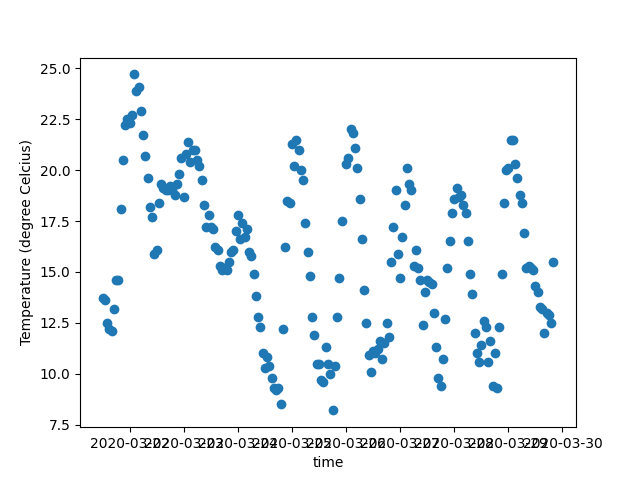

In [11]:
%matplotlib notebook
import matplotlib.pyplot as plt
from matplotlib.dates import date2num

plt.xlabel('time')
plt.ylabel('Temperature (degree Celcius)')
plt.plot_date(date2num(dset.time), dset.tmp.data)